In [1]:
import sys
import os
#import torch
import zarr
import fsspec
import lilio
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt

#from torch import nn
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from scripts.prepare_monthly_ts_data import get_monthly_data
from Medley.preprocessing import Anomalizer

In [2]:
warnings.simplefilter('ignore',category=RuntimeWarning)
warnings.simplefilter('ignore',category=UserWarning)

### Defining predictand
TODO: also eastern Europe. And extract both WSD and EOBS

In [3]:
# blocks to include and exclude. Lonmin, latmin, lonmax, latmax
include = {'iberia':(-9.8,35.98,3.6,43.8),
          'france_italy':(4,43,13.4,45.63)}
exclude = {'islands':(0.79,35.2,4.6,40.4),
          'north_africa':(-1.450,34.457,11.217,36.972)}

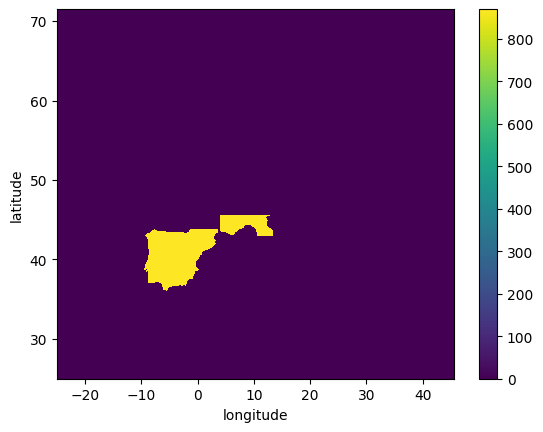

In [4]:
rrmon = xr.open_zarr('/scistor/ivm/jsn295/Medi/monthly/rr_mon_ens_mean_0.1deg_reg_v26.0e.zarr/')['rr']
example = rrmon.isel(time = 0, drop =True)
mask = xr.DataArray(np.full_like(example, 0), coords = example.coords)
def set_subset_to(lonmin, latmin, lonmax, latmax, array, value):
    lons = array.sel(longitude = slice(lonmin, lonmax)).longitude
    lats = array.sel(latitude = slice(latmin, latmax)).latitude
    array.loc[lats,lons] = value # cannot do .sel based assignment
for args in include.values():
    set_subset_to(*args, array = mask, value = 1)
for args in exclude.values():
    set_subset_to(*args, array = mask, value = 0)
count = xr.where(mask,rrmon,np.nan).count('time').compute()
count.plot()

In [6]:
# Precip trends per season/month?

In [5]:
df = get_monthly_data().to_pandas()
target = xr.where(mask,rrmon,np.nan).mean(['longitude','latitude']).compute().to_dataframe(name = 'rrmon')
target.columns = pd.MultiIndex.from_tuples([('rrmon',0,'EOBS')], names = df.columns.names)
df = df.loc[target.index,:]

In [7]:
def estimate_gmstcoef(series):
    x = df.loc[series.index, 'gmst']
    ln = LinearRegression()
    ln.fit(X = x, y = series.squeeze())
    return ln.coef_[0]

In [9]:
mcoefs = target.groupby(target.index.month).apply(estimate_gmstcoef)
mcoefs.name = 'trend mm/degree'

<Axes: xlabel='time'>

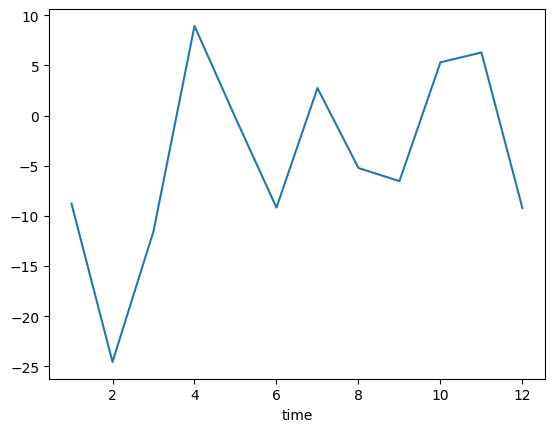

In [10]:
mcoefs.plot()

In [11]:
# April seems to have been wettening. February and March most clearly drying.
#target.loc[target.index.month == 4,:].plot()

<Axes: xlabel='time'>

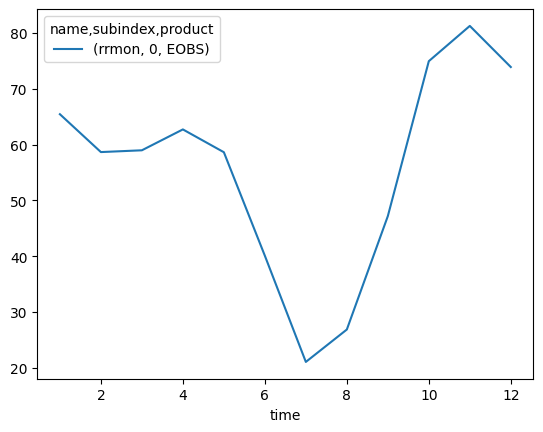

In [16]:
target.groupby(target.index.month).mean().plot()

## trends in predictors

In [8]:
cal = lilio.Calendar(anchor = '12-01')
#cal.add_intervals("target", length="1M", gap = '0M')
cal.add_intervals("precursor", length="4M", n=1, gap = '-4M') # Fully co-occurring
#cal.add_intervals("precursor", length="1M", n=3, gap = '0M')
cal.map_years(start=1949, end=2023)

Calendar(
    anchor='12-01',
    allow_overlap=False,
    mapping=('years', 1949, 2023),
    intervals=[
        Interval(role='precursor', length='4M', gap='-4M')
    ]
)

In [9]:
test = lilio.resample(cal,df.join(target), how = 'nanmean').set_index('anchor_year').iloc[:,2:-1]
test.columns = pd.MultiIndex.from_tuples(test.columns, names = df.columns.names)

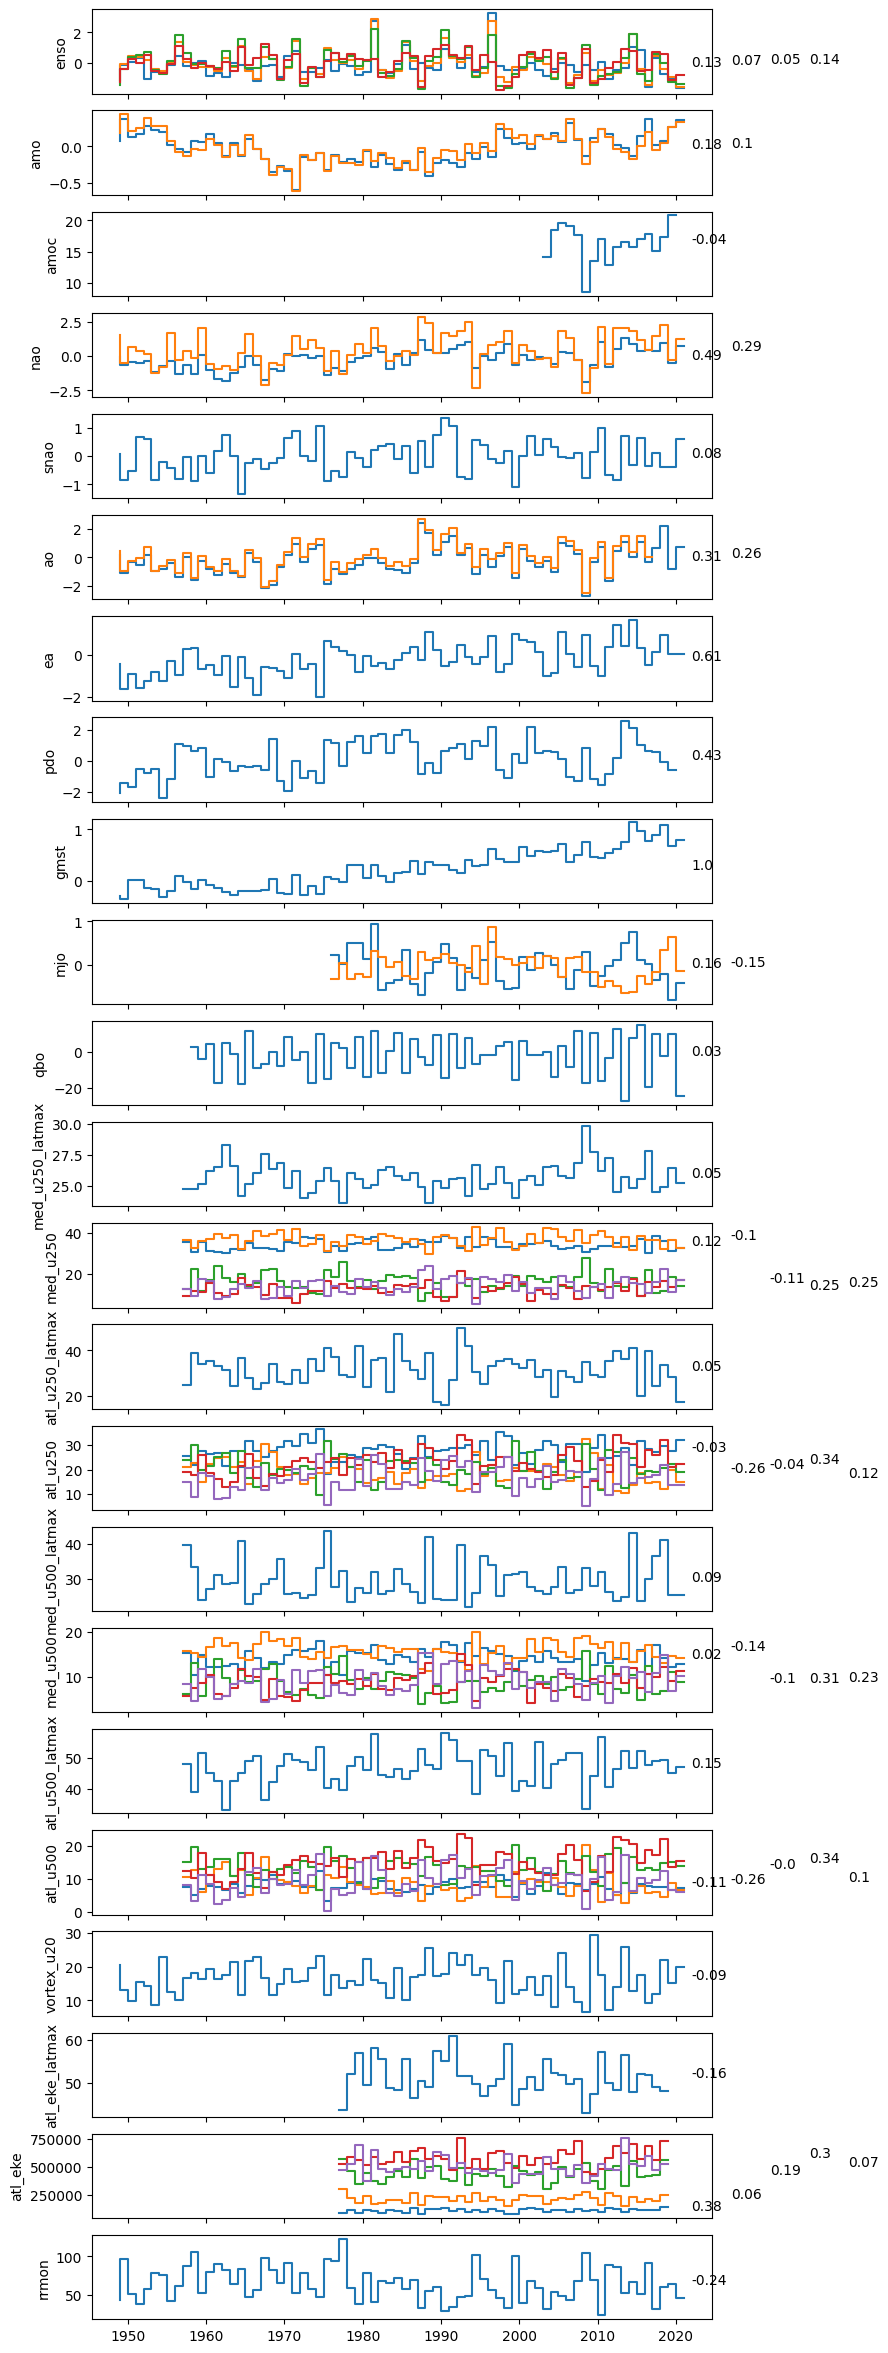

In [10]:
gmst = test['gmst'].squeeze()
names = test.columns.get_level_values('name').unique()
fig, axes = plt.subplots(nrows = len(names), sharex = True, figsize = (8,30))
for i, name in enumerate(names):
    ax = axes[i]
    dat = test.loc[:,name]
    for j,col in enumerate(dat.columns):
        series = dat[col]
        corr = pearsonr(gmst.loc[~series.isnull()],series.loc[~series.isnull()])
        ax.text(2022+5*j,series.mean(), s = np.round(corr[0],2))
        ax.step(test.index, series, label = col)
    ax.set_ylabel(name)

East Atlantic pattern pretty trended. Strong correlation with GMST
Also the blue NAO index is quite trended.

#### Seasonality at multiple timescales.

/tmp/ipykernel_2794049/2665685714.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.groupby(df.index.month).mean().drop('atl_eke', axis = 1).plot()


<Axes: xlabel='time'>

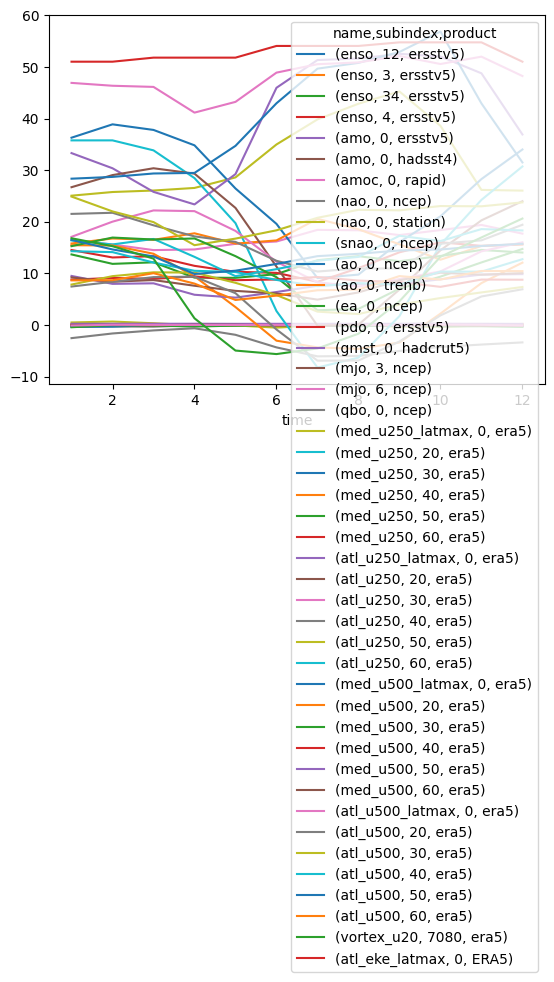

In [11]:
df.groupby(df.index.month).mean().drop('atl_eke', axis = 1).plot()

In [12]:
a = Anomalizer()
a.fit(df.join(target)) # Computing all climates
anom = a.transform(df)
anom_target = a.transform(target)


#### Correlation Matrices at multiple timescales.

In [14]:
def simultaneous_resample(combined, firstmonth = 12, lastmonth = 1, average = True):
    """
    lastmonth is inclusive
    """
    if firstmonth > lastmonth:
        months = np.arange(firstmonth - 12, lastmonth + 1, 1)
        months  = np.where(months <=0, months + 12, months)
    else:
        months = np.arange(firstmonth, lastmonth + 1, 1)
    if average:
        cal = lilio.Calendar(anchor = f'{firstmonth}-01')
        cal.add_intervals("precursor", length=f"{len(months)}M", n=1, gap = f'-{len(months)}M') # Fully co-occurring
    else:
        cal = lilio.Calendar(anchor = f'{lastmonth}-01')
        cal.add_intervals("precursor", length="1M", n=1, gap = '-1M') # Fully co-occurring
        if len(months) > 1:
            cal.add_intervals("precursor", length="1M", n=len(months)-1, gap = '0M') # Fully co-occurring
    cal.map_years(start=1949, end=2023)
    res = lilio.resample(cal, combined, how = 'nanmean')
    res = res.set_index(['anchor_year','i_interval','interval']).drop('is_target', axis = 1) # Lilio bookkeeping
    res.columns = pd.MultiIndex.from_tuples(res.columns, names = df.columns.names)
    return res

def lagged_resample(combined, separation = 0, firstmonth = 12, lastmonth = 12, n = 1, precursor_agg = 1, allow_precursor_overlap = False):
    """
    Separation between target and first precursor is in terms of number of months.
    Always an averaging is applied.
    Averaging period for target is determined by firstmonth / lastmonth interval (lastmonth is inclusive)
    Averaging period for precursor is given as integer in number of months
    if precursor_agg > 1, you can opt for allowing overlap. 
    """
    if firstmonth > lastmonth:
        months = np.arange(firstmonth - 12, lastmonth + 1, 1)
        months  = np.where(months <=0, months + 12, months)
    else:
        months = np.arange(firstmonth, lastmonth + 1, 1)
    cal = lilio.Calendar(anchor = f'{firstmonth}-01')
    cal.add_intervals("target", length=f"{len(months)}M")
    counter = n
    while counter > 0:
        if counter == n: # First precursor
            gap = separation
        elif (precursor_agg > 1) and allow_precursor_overlap:
            gap = -(precursor_agg - 1)
        else:
            gap = 0
        cal.add_intervals("precursor", length=f"{precursor_agg}M", n=1, gap = f'{gap}M')
        counter -= 1
    cal.map_years(start=1949, end=2023)
    res = lilio.resample(cal, combined, how = 'nanmean')
    res = res.set_index(['anchor_year','i_interval']).drop('interval', axis = 1)
    y = res.loc[res['is_target'],[('rrmon',0,'EOBS')]].unstack('i_interval')
    X = res.loc[~res['is_target'],:].drop([('rrmon',0,'EOBS'),'is_target'], axis = 1).unstack('i_interval')
    X.columns.names = ['variables','i_interval']
    #X.columns = pd.MultiIndex.from_tuples(X.columns) # Should be done before unstacking
    return X, y, cal # Also return the calendar for bookkeeping.

# Do I need a lagged but multi

In [28]:
exampledf = simultaneous_resample(combined = df.join(target), firstmonth = 1, lastmonth = 1, average = False)
# Plotting correlations per month, single months
#corwith = ('gmst',0,'hadcrut5')
corwith = ('rrmon',0,'EOBS')
othervars = exampledf.columns.drop(corwith)
months = [10,11,12,1,2,3,4,5]
corrcoefs = xr.DataArray(np.full((len(months),len(othervars)),np.nan), dims = ('month','variables'),
                        coords = {'month':months, 'variables':othervars}, name = 'spearmanr')
for month in months:
    monthly = simultaneous_resample(combined = df.join(target), firstmonth = month, lastmonth = month, average = False)
    for var in othervars:
        dat = monthly.loc[:,[var,corwith]].dropna(how = 'any')
        corrcoefs.loc[month,var] = spearmanr(dat)[0]

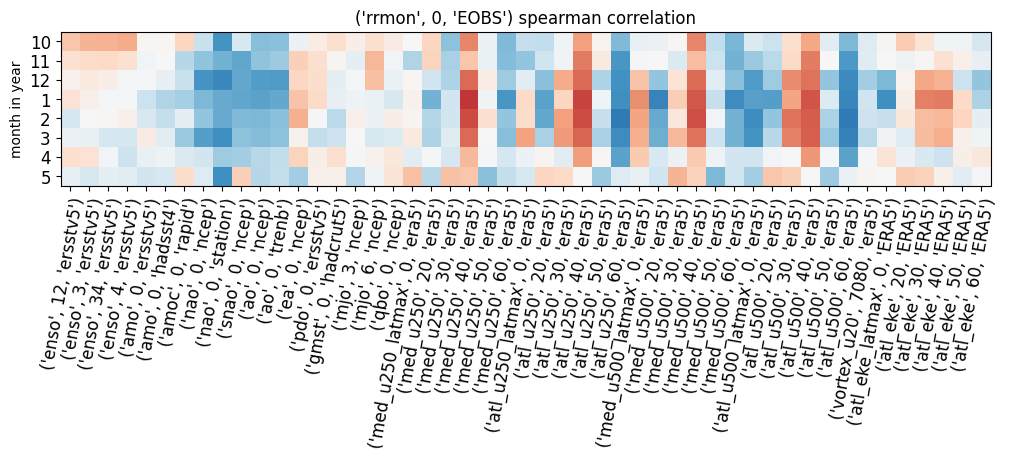

In [29]:
fig, ax = plt.subplots(figsize = (12,2))
im = ax.imshow(corrcoefs.values, vmin = -1, vmax = 1, cmap = 'RdBu_r', aspect = 'auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(corrcoefs.shape[1]))
ax.set_xticklabels(corrcoefs.indexes['variables'].to_flat_index().values, size = 12)
ax.set_yticks(np.arange(corrcoefs.shape[0]))
ax.set_yticklabels(corrcoefs.indexes['month'].values, size = 12)
ax.set_title(f'{corwith} spearman correlation')
ax.set_ylabel('month in year')

plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
         rotation_mode="anchor")
plt.show()

MJO phase 6 is interesting, enso in october. NAO entire winter, station based is better.

In [118]:
# Plotting correlations for multiple months aggregation, starting november
#corwith = ('gmst',0,'hadcrut5')
corwith = ('rrmon',0,'EOBS')
othervars = exampledf.columns.drop(corwith)
startmonth = 12
endmonths = [12,1,2,3,4]
corrcoefs = xr.DataArray(np.full((len(months),len(othervars)),np.nan), dims = ('month','variables'),
                        coords = {'month':months, 'variables':othervars}, name = 'spearmanr')
for month in endmonths:
    monthly = simultaneous_resample(combined = df.join(target), firstmonth = startmonth, lastmonth = month, average = True)
    for var in othervars:
        dat = monthly.loc[:,[var,corwith]].dropna(how = 'any')
        corrcoefs.loc[month,var] = spearmanr(dat[var],dat[corwith])[0]

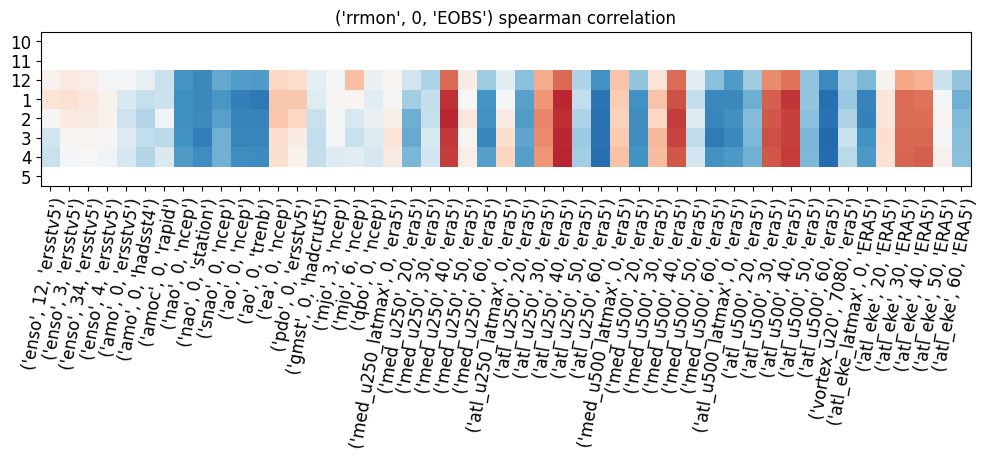

In [119]:
fig, ax = plt.subplots(figsize = (12,2))
im = ax.imshow(corrcoefs.values, vmin = -1, vmax = 1, cmap = 'RdBu_r', aspect = 'auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(corrcoefs.shape[1]))
ax.set_xticklabels(corrcoefs.indexes['variables'].to_flat_index().values, size = 12)
ax.set_yticks(np.arange(corrcoefs.shape[0]))
ax.set_yticklabels(corrcoefs.indexes['month'].values, size = 12)
ax.set_title(f'{corwith} spearman correlation')

plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
         rotation_mode="anchor")
plt.show()

### Simultaneous univariate association
Functions of sklearn (mutual_info_regression, f_regression) could be called by themselves in this univariate setting. Does in principle not need wrapping in SelectKBest

In [20]:
from sklearn.feature_selection import mutual_info_regression, f_regression

In [22]:
dropped = df.drop('amoc', axis = 1).dropna()
target_dropped = target.loc[dropped.index,:].squeeze()

/tmp/ipykernel_3613542/1718627699.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dropped = df.drop('amoc', axis = 1).dropna()


In [23]:
exampledf = simultaneous_resample(combined = df.join(target), firstmonth = 1, lastmonth = 1, average = False)
# Plotting correlations per month, single months
#corwith = ('gmst',0,'hadcrut5')
corwith = ('rrmon',0,'EOBS')
othervars = exampledf.columns.drop(corwith)
months = [10,11,12,1,2,3,4,5]
coefs = xr.DataArray(np.full((len(months),len(othervars)),np.nan), dims = ('month','variables'),
                        coords = {'month':months, 'variables':othervars}, name = 'f_stat')
pvals = xr.DataArray(np.full((len(months),len(othervars)),np.nan), dims = ('month','variables'),
                        coords = {'month':months, 'variables':othervars}, name = 'p_val')
for month in months:
    monthly = simultaneous_resample(combined = df.join(target), firstmonth = month, lastmonth = month, average = False)
    for var in othervars: 
        dat = monthly.loc[:,[var,corwith]].dropna(how = 'any') # Per var, because otherwise all are limited by shortest length
        coefs.loc[[month],var], pvals.loc[[month],var] = f_regression(X = dat[[var]], y = dat[corwith])
        #coefs.loc[[month],var] = mutual_info_regression(X = dat[[var]], y = dat[corwith])
#selector = SelectKBest(score_func = , k = 3)
#selector.fit(X = dropped, y = target_dropped)
#selector.scores_


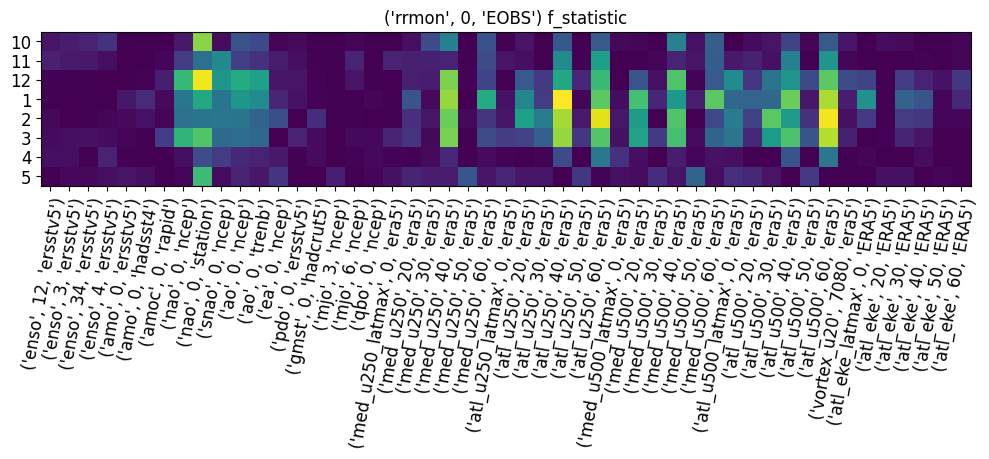

In [24]:
fig, ax = plt.subplots(figsize = (12,2))
im = ax.imshow(coefs.values, aspect = 'auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(coefs.shape[1]))
ax.set_xticklabels(coefs.indexes['variables'].to_flat_index().values, size = 12)
ax.set_yticks(np.arange(coefs.shape[0]))
ax.set_yticklabels(coefs.indexes['month'].values, size = 12)
ax.set_title(f'{corwith} f_statistic')

plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
         rotation_mode="anchor")
plt.show()

### Lagged univariate association

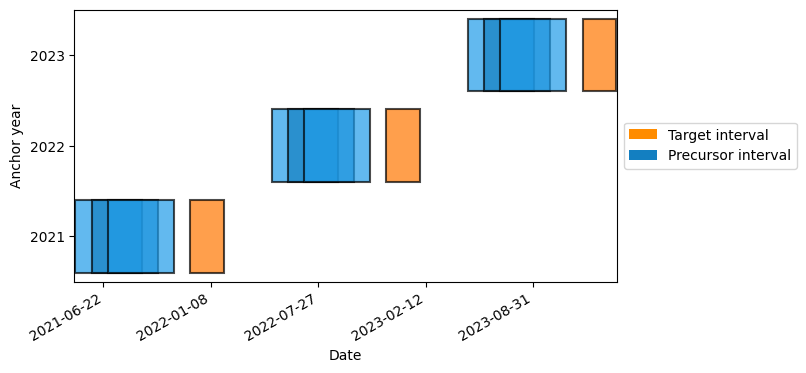

In [26]:
# Showcase
X, y, cal = lagged_resample(lastmonth = 1, separation = 1, n = 3, precursor_agg = 4, allow_precursor_overlap=True)
cal.visualize()

In [23]:
precursor_agg = 2
separation = 0
X, y, cal = lagged_resample(combined = anom.join(anom_target), firstmonth=12, lastmonth = 3, separation = separation, n = 3, precursor_agg = precursor_agg, allow_precursor_overlap=True)
y = y.dropna()
variables = X.columns.get_level_values(0).unique().values
#shifts = X.columns.get_level_values(-1).unique().values
coefs = xr.DataArray(np.full((X.shape[-1],),np.nan), dims = ('stacked_index',),
                        coords = {'stacked_index':X.columns}, name = 'correlation')
for var in variables: 
    X_subset = X.loc[:,(var, slice(None))].dropna(how = 'any') # Per var, because otherwise all are limited by shortest length
    ind = X_subset.index.intersection(y.index)
    coefs.loc[X_subset.columns], _ = f_regression(X = X_subset.loc[ind,:], y = y.loc[ind])
coefs = coefs.unstack('stacked_index').T

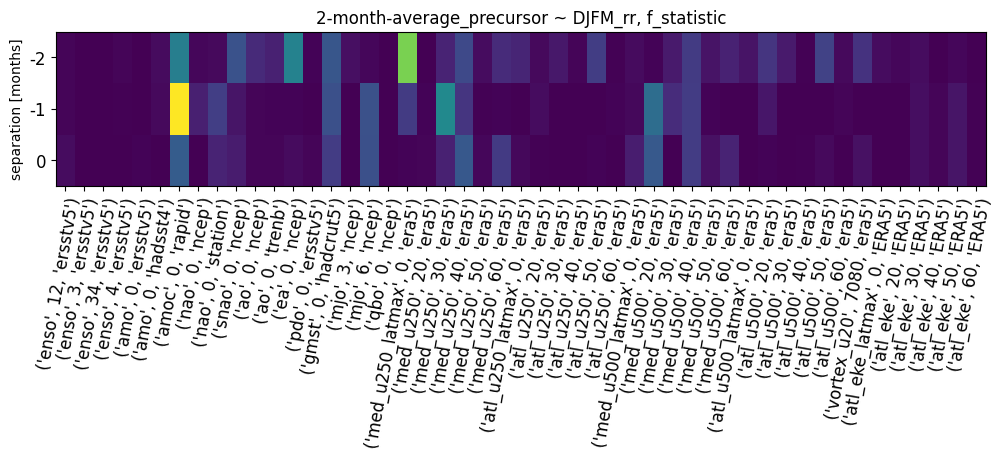

In [25]:
fig, ax = plt.subplots(figsize = (12,2))
im = ax.imshow(coefs.values, aspect = 'auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(coefs.shape[1]))
ax.set_xticklabels(coefs.indexes['variables'].to_flat_index().values, size = 12)
ax.set_yticks(np.arange(coefs.shape[0]))
ax.set_yticklabels((coefs.indexes['i_interval'].values + 1) + separation, size = 12)
ax.set_ylabel('separation [months]')
ax.set_title(f'{precursor_agg}-month-average_precursor ~ DJFM_rr, f_statistic')

plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
         rotation_mode="anchor")
plt.show()

Only two beating the association with GMST are AMOC (not AMO) and mediterranean 250hpa position. Interesting how NAO completely disappears (only strong simultaneous).

QBO and ENSO, seen as modulators by Marlene do not show up. Because of indirect influence? Also SPV not super strong. In Marlene's analysis she uses 30-day QBO and ENSO, influencing t2m in week 3. 

TODO: check shorter timescales. MJO and Vortex in Marlene's analysis are namely weekly. But month is lowest I can do.

In [31]:
precursor_agg = 1
separation = 0
X, y, cal = lagged_resample(combined = df.join(target).loc['1999':,:], firstmonth=12, lastmonth = 3, separation = separation, n = 4, precursor_agg = precursor_agg, allow_precursor_overlap=True)
y = y.dropna()
variables = X.columns.get_level_values(0).unique().values
#shifts = X.columns.get_level_values(-1).unique().values
coefs = xr.DataArray(np.full((X.shape[-1],),np.nan), dims = ('stacked_index',),
                        coords = {'stacked_index':X.columns}, name = 'correlation')
for var in variables: 
    X_subset = X.loc[:,(var, slice(None))].dropna(how = 'any') # Per var, because otherwise all are limited by shortest length
    ind = X_subset.index.intersection(y.index)
    coefs.loc[X_subset.columns], _ = f_regression(X = X_subset.loc[ind,:], y = y.loc[ind])
coefs = coefs.unstack('stacked_index').T

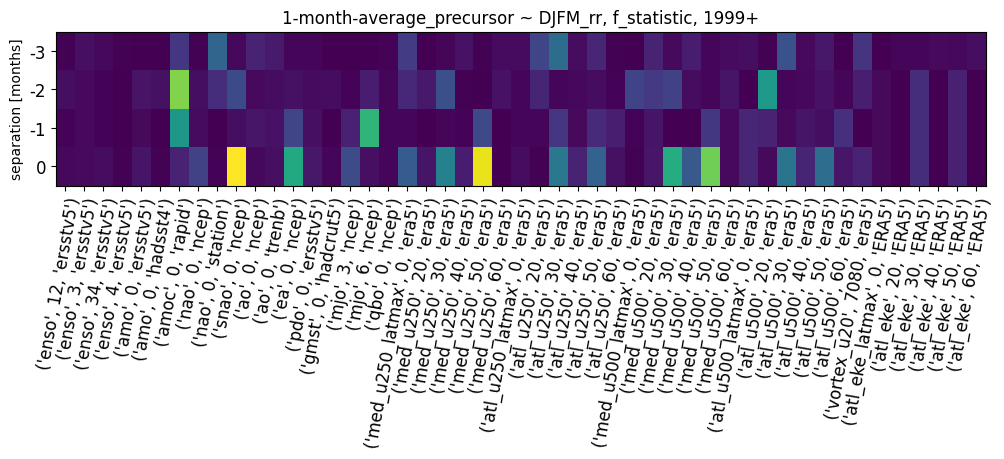

In [33]:
fig, ax = plt.subplots(figsize = (12,2))
im = ax.imshow(coefs.values, aspect = 'auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(coefs.shape[1]))
ax.set_xticklabels(coefs.indexes['variables'].to_flat_index().values, size = 12)
ax.set_yticks(np.arange(coefs.shape[0]))
ax.set_yticklabels((coefs.indexes['i_interval'].values + 1) + separation, size = 12)
ax.set_ylabel('separation [months]')
ax.set_title(f'{precursor_agg}-month-average_precursor ~ DJFM_rr, f_statistic, 1999+')

plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
         rotation_mode="anchor")
plt.show()

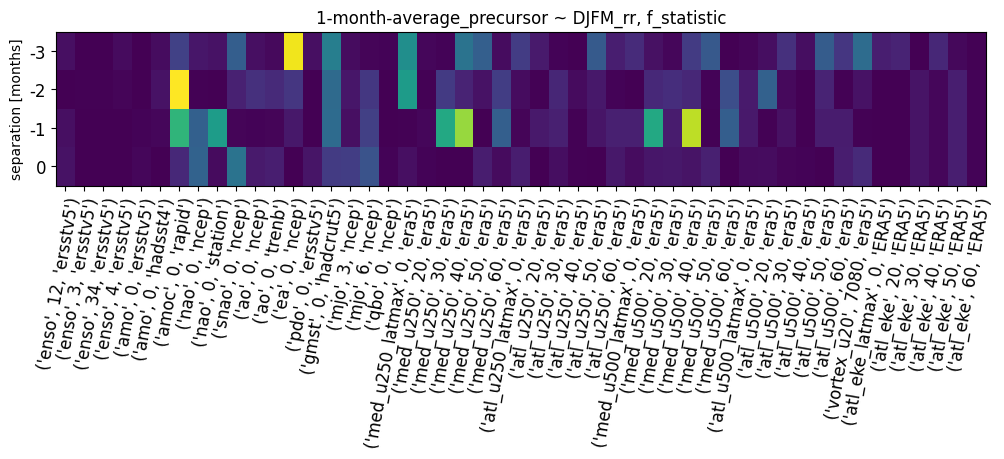

In [27]:
fig, ax = plt.subplots(figsize = (12,2))
im = ax.imshow(coefs.values, aspect = 'auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(coefs.shape[1]))
ax.set_xticklabels(coefs.indexes['variables'].to_flat_index().values, size = 12)
ax.set_yticks(np.arange(coefs.shape[0]))
ax.set_yticklabels((coefs.indexes['i_interval'].values + 1) + separation, size = 12)
ax.set_ylabel('separation [months]')
ax.set_title(f'{precursor_agg}-month-average_precursor ~ DJFM_rr, f_statistic')

plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
         rotation_mode="anchor")
plt.show()

### Model specific selection
Needs wrapping in SequentialFeatureSelector or RFE

In [72]:
# How to set up the crossvalidation if the length of the data changes per predictor, and with the shortest being too short
# Model agnostic, non-performance-based, also needs CV?

# Simple approach would be to resample data once and require (dropping e.g. AMOC)

In [ ]:
# Accepts any scoring function, so can be combined with multiple trials and averaging.

def scoring_func(model, X:np.ndarray, y:np.ndarray) -> tuple[np.ndarray,np.ndarray]:
    """ wrapping crossvalidation, repeated model fitting"""
    pass

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to('cuda')

In [ ]:
model(torch.randn((784,)).to('cuda'))